# mESC analysis using the object oriented core

We use the mESC dataset. For simplicity we have converted the dataset into TPM.
The original count data is available at ArrayExpress: 
[E-MTAB-2805](https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-2805/). 
Tools to transform data are also provided and explained in the following sections.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 1

In [2]:
import pandas as pd
import numpy as np
import sklearn as skl

In [3]:
from cyclum.models.misc import cyclops
from cyclum import writer


Using TensorFlow backend.


## Read data
Here we have label, so we load both. However, the label is not used until evaluation.

In [4]:
input_file_mask = '/home/shaoheng/Documents/data/mESC/mesc-tpm'

def preprocess(input_file_mask):
    """
    Read in data and perform log transform (log2(x+1)), centering (mean = 1) and scaling (sd = 1).
    """
    tpm = writer.read_df_from_binary(input_file_mask).T
    sttpm = pd.DataFrame(data=skl.preprocessing.scale(np.log2(tpm.values + 1)), index=tpm.index, columns=tpm.columns)
    
    label = pd.read_csv(input_file_mask + '-label.txt', sep="\t", index_col=0).T
    return sttpm, label

sttpm, label = preprocess(input_file_mask)

In [5]:
sttpm.shape

(288, 38293)

There is no convention whether cells should be columns or rows. Here we require cells to be rows.

## Set up the model and fit the model


In [6]:
import numpy
import sklearn.decomposition

data = cyclops.prep(sttpm.values, variance_kept = 0.98)
data=skl.preprocessing.scale(data)

[0.85776666 0.95548825 0.96553876 0.97004382 0.97152918 0.97273429
 0.97381168 0.97455719 0.97518402 0.97572126 0.97617094 0.97655431
 0.9769163  0.97727052 0.97755856 0.97782615 0.97808301 0.97833217
 0.97857597 0.97880018 0.97901828 0.97923484 0.97943381 0.97962482
 0.97980796 0.97999032 0.98016522 0.9803381  0.98050743 0.98067421
 0.98083874 0.98099936 0.98115832 0.98131545 0.98146897 0.9816198
 0.98177014 0.98191956 0.98206612 0.98221184 0.98235603 0.98249903
 0.98264019 0.98277946 0.98291714 0.98305255 0.98318741 0.98332126
 0.98345384 0.98358452 0.98371449 0.98384363 0.98397084 0.98409691
 0.9842219  0.98434596 0.9844692  0.98459071 0.98471198 0.98483257
 0.98495194 0.98507033 0.98518842 0.98530525 0.98542144 0.98553679
 0.98565108 0.98576484 0.98587788 0.98598992 0.98610064 0.98621033
 0.98631956 0.98642815 0.98653605 0.98664305 0.98674904 0.98685472
 0.98695986 0.98706453 0.98716853 0.98727198 0.9873747  0.98747661
 0.98757842 0.98767979 0.98777987 0.98787951 0.98797862 0.98807

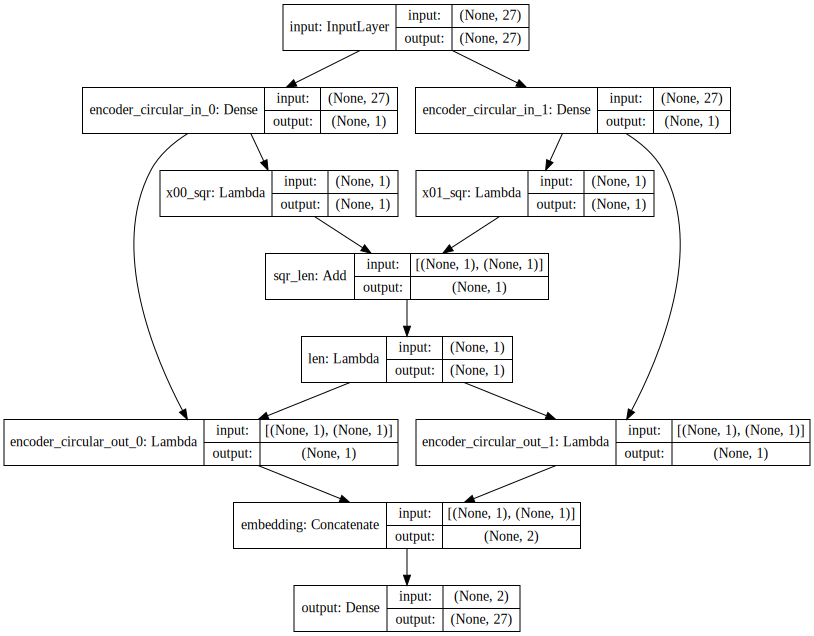

In [7]:
model = cyclops(data.shape[1])
display(model.show_structure())

In [8]:
model.train(data, epochs=1000, verbose=100, rate=2e-3)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


epoch: 100/1000, loss:  0.9359, time elapsed:  4.16s, time left:  37.40s
epoch: 200/1000, loss:  0.9340, time elapsed:  6.87s, time left:  27.47s
epoch: 300/1000, loss:  0.9329, time elapsed:  9.42s, time left:  21.98s
epoch: 400/1000, loss:  0.9326, time elapsed:  12.11s, time left:  18.17s
epoch: 500/1000, loss:  0.9322, time elapsed:  14.85s, time left:  14.85s
epoch: 600/1000, loss:  0.9318, time elapsed:  17.60s, time left:  11.73s
epoch: 700/1000, loss:  0.9315, time elapsed:  20.31s, time left:  8.70s
epoch: 800/1000, loss:  0.9313, time elapsed:  23.08s, time left:  5.77s
epoch: 900/1000, loss:  0.9312, time elapsed:  25.84s, time left:  2.87s
epoch: 1000/1000, loss:  0.9313, time elapsed:  28.58s, time left:  0.00s


In [9]:
pseudotime = model.predict_pseudotime(data)


## Illustrations
We illustrate the results on a circle, to show its circular nature. 
There is virtually no start and end of the circle.
Red, green and blue represents G0/G1, S and G2/M phase respectively.
The inner lines represents single cells. The cells spread across the
The areas outside

In [10]:
import cyclum.illustration

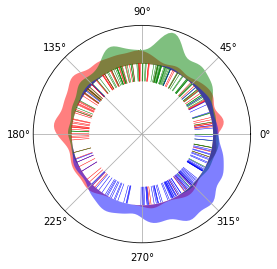

In [11]:
color_map = {'stage': {"g0/g1": "red", "s": "green", "g2/m": "blue"},
                 'subcluster': {"intact": "cyan", "perturbed": "violet"}}
cyclum.illustration.plot_round_distr_color(pseudotime, label['stage'], color_map['stage'])
pass

In [12]:
from cyclum.hdfrw import mat2hdf

mat2hdf(pseudotime, '/home/shaoheng/Documents/data/EMTAB2805/cyclops-pseudotime.h5')
